In [1]:
import torch 
import torch.nn as nn

In [2]:
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']} # information of output channels 

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.fc1 = nn.Linear(512, 64)                       # VGG have 3 fc layer at the end of network 
        self.fc2 = nn.Linear(64, 32)        
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.features(x)                              
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers) # list type can be referenced 

In [4]:
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = VGG('VGG11')
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma =0.1)

In [7]:
def train(epoch):
    net.train()
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # to GPU 
        labels = labels.to(device)  
        optimizer.zero_grad()       
        outputs = net(inputs)       
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 30 ==29:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(net.state_dict(), './VGG_model.pth')             # save the model's weight
            torch.save(optimizer.state_dict(), './VGG_optimizer.pth')   # sace the information of optimizer (learning rate)

In [8]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)      
            total += labels.size(0)
            correct += (predicted == labels).sum().item()    # when index of maximum value and label is same  
            test_loss += loss.item()
    test_losses.append(test_loss/batch_idx+1)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss/(batch_idx+1), correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    accuracy.append(100. * correct / len(test_loader.dataset))

In [9]:
epochs = 50
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
accuracy = []

In [10]:
test()
since = time.time()
epochs = 50
for epoch in range(0, epochs):
    train(epoch)
    test()
finish = time.time()
print('Training Finished in {}min'.format((finish - since)//60))


Test set: Avg. loss: 2.3068, Accuracy: 1000/10000 (10%)

Train Epoch: 0 [58/50000 (7%)]	Loss: 1.665959
Train Epoch: 0 [118/50000 (15%)]	Loss: 1.631391
Train Epoch: 0 [178/50000 (23%)]	Loss: 1.530458
Train Epoch: 0 [238/50000 (30%)]	Loss: 1.356812
Train Epoch: 0 [298/50000 (38%)]	Loss: 1.606957
Train Epoch: 0 [358/50000 (46%)]	Loss: 1.288422
Train Epoch: 0 [418/50000 (53%)]	Loss: 1.096987
Train Epoch: 0 [478/50000 (61%)]	Loss: 1.068506
Train Epoch: 0 [538/50000 (69%)]	Loss: 1.014163
Train Epoch: 0 [598/50000 (76%)]	Loss: 1.334432
Train Epoch: 0 [658/50000 (84%)]	Loss: 0.908247
Train Epoch: 0 [718/50000 (92%)]	Loss: 1.197862
Train Epoch: 0 [778/50000 (99%)]	Loss: 1.118513

Test set: Avg. loss: 1.2029, Accuracy: 5989/10000 (60%)

Train Epoch: 1 [58/50000 (7%)]	Loss: 1.160465
Train Epoch: 1 [118/50000 (15%)]	Loss: 0.951604
Train Epoch: 1 [178/50000 (23%)]	Loss: 0.887470
Train Epoch: 1 [238/50000 (30%)]	Loss: 0.825341
Train Epoch: 1 [298/50000 (38%)]	Loss: 0.891709
Train Epoch: 1 [358/5000

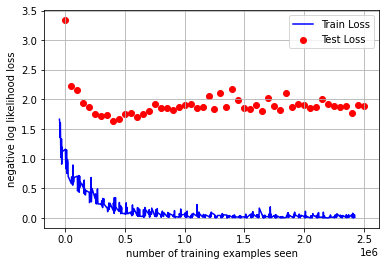

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.plot()
plt.grid()

[]

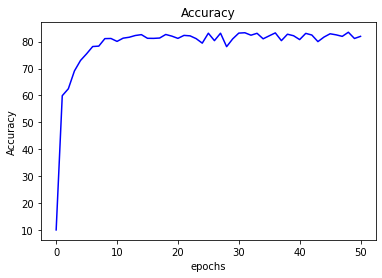

In [12]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(range(len(accuracy)), accuracy, color = 'blue')
plt.plot()